In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
import numpy as np
import pandas as pd
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

In [94]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [95]:
datasets = list(DATA_DIR.glob('embeddings/0.5/*/*.pickle'))
datasets = pd.DataFrame([[i.parent.stem, i.stem, i] for i in datasets], columns = ['ds', 'indv', '_loc'])
mask = np.array([i[:3] == '0.5' for i in datasets.indv.values])
datasets = datasets[mask]
datasets['indv'] = np.array([i[4:] for i in datasets.indv.values])
datasets[:3]

,ds,indv,_loc
1,castellucci_mouse_usv_segmented,VOC597,/local/home/tsainbur/github_repos/avgn_paper/d...
3,castellucci_mouse_usv_segmented,VOC592,/local/home/tsainbur/github_repos/avgn_paper/d...
4,castellucci_mouse_usv_segmented,VOC591,/local/home/tsainbur/github_repos/avgn_paper/d...


In [96]:
datasets.ds.unique()

array(['castellucci_mouse_usv_segmented', 'BIRD_DB_Vireo_cassinii',
       'gibbon_morita_segmented', 'bengalese_finch_sober',
       'batsong_segmented', 'BIRD_DB_Toxostoma_redivivum', 'buckeye',
       'swamp_sparrow', 'mobysound_humpback_whale',
       'koumura_bengalese_finch', 'katahira_white_munia_segmented',
       'canary_segmented', 'zebra_finch_gardner_segmented', 'giant_otter',
       'european_starling_gentner_segmented'], dtype=object)

In [97]:
ds_loc = datasets[datasets.ds == 'swamp_sparrow'].iloc[0]._loc
ds_loc

PosixPath('/local/home/tsainbur/github_repos/avgn_paper/data/embeddings/0.5/swamp_sparrow/0.5_full.pickle')

In [98]:
syllable_df = pd.read_pickle(ds_loc)

In [99]:
syllable_df[:3]

,start_time,end_time,syllable,pos_in_syllable,indv,indvi,key,rate,spectrogram,umap
0,0.1015,0.1160,0.0,0.0,NYMONT33,0,SWSP09MONT33P1,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.10409524291753769, -2.663280963897705]"
1,0.1460,0.2095,0.0,1.0,NYMONT33,0,SWSP09MONT33P1,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-6.805121421813965, -11.6214017868042]"
2,0.2510,0.2620,1.0,0.0,NYMONT33,0,SWSP09MONT33P1,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.056673408, 0.0122...","[-2.296152353286743, -3.6518876552581787]"


In [100]:
### get population info

In [101]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [102]:
DATASET_ID = 'swamp_sparrow'
hparams = HParams()
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    7.0s


[Parallel(n_jobs=-1)]: Done 1867 out of 1867 | elapsed:    7.2s finished


In [103]:
population = [
    str(i)
    for i in np.array(
        [
            dataset.data_files[key].data["POPID"] if key in dataset.data_files else None
            for key in syllable_df.key.values
        ]
    )
]
np.unique(population)

array(['Adirondacks, NY', 'Conneaut, PA', 'Horicon, WI',
       'Hudson Valley, NY', 'Montezuma, NY', 'None', 'Waterloo, MI'],
      dtype='<U17')

In [104]:
syllable_df['population'] = population

In [105]:
mask = syllable_df.population != 'None'
syllable_df = syllable_df[mask]

In [106]:
specs = np.stack(syllable_df['spectrogram'].values)
embedding = np.vstack(syllable_df['umap'].values)

In [107]:
np.shape(embedding)

(97513, 2)

In [108]:
def remove_outliers(z, pct = 99.5):
    """ GPU based UMAP algorithm produces some outliers that UMAP does not, but is much faster
    this is a quick fix for that. 
    """
    _min = np.percentile(z, (100-pct), axis=0)
    _max = np.percentile(z, pct, axis=0)
    for col in range(np.shape(z)[1]):
        mask = z[:,col] < _min[col]
        z[mask,col] = _min[col]
        mask = z[:,col] > _max[col]
        z[mask,col] = _max[col]
    return z

(-15, 15)

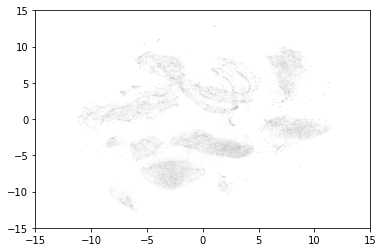

In [109]:
fig, ax = plt.subplots()
ax.scatter(embedding[:,0], embedding[:,1], s=1, color='k', alpha = 0.005)
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])

In [110]:
embedding[:,0] = embedding[:,0]*-1

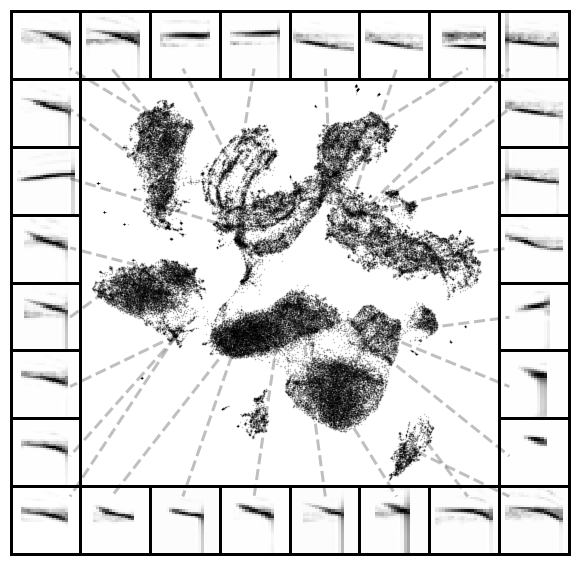

In [120]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        #'labels': syllable_df.labels.values[:nex],
        'alpha':0.25,
        's': 0.25,
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp', dpi=300, save_jpg=True, save_png=True)

In [121]:
np.shape(embedding)

(97513, 2)

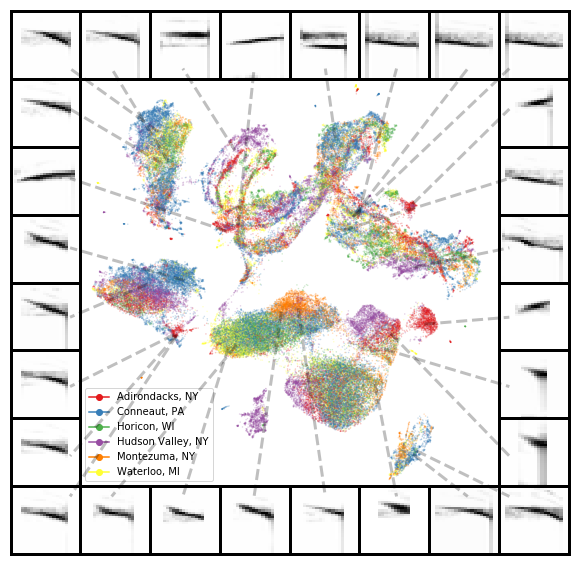

In [122]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': syllable_df.population.values[:nex],
        'alpha':0.25,
        's': 0.25,
        'show_legend': True,
        'color_palette':'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp_community', dpi=300, save_jpg=True, save_png=True)